In [88]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from chart_studio import plotly 
from  plotly.offline import iplot
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [89]:

def read_data(folder_name):
    # convert json to csv:
    path=os.getcwd()+"\\"+folder_name
    for filename in os.listdir(path): 
        root, ext = os.path.splitext(filename) 
        if ext == '.json': 
            file = pd.read_json(path+"\\"+filename,orient='records')
            file=file.loc[file['sensor']=="Gyroscope"] # Select gyro data 
            file.to_csv(path+"\\"+root + '.csv',index=False,columns=['seconds_elapsed','z','y','x'])

    examples = [] # Empty examples array
    example_names = []
    for f in sorted(glob.glob(folder_name + "/*.csv")):
        filename = f[f.find('/') + 1:-4]
        example = pd.read_csv(f, header=0)
        example = example.apply(pd.to_numeric, errors='coerce')
        example_names.append(filename)
        examples.append(example)
    return example_names, examples

swings=["Serves","BH","FH"] # Define Classes
examples = {} #Creatig dict to hold data for each class 
example_names = {}
for swing in swings: 
    example_names[swing], examples[swing] = read_data(swing)



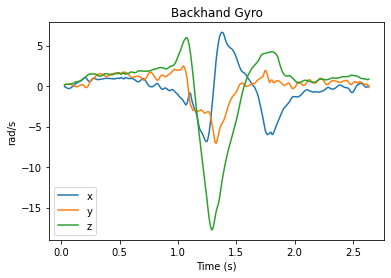

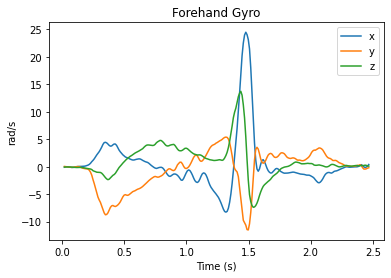

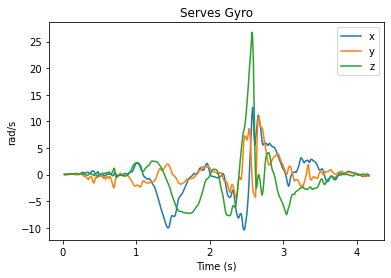

In [90]:

# Random Example From Each Class
examples["BH"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Backhand Gyro",ylabel="rad/s",xlabel="Time (s)")
examples["FH"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Forehand Gyro",ylabel="rad/s",xlabel="Time (s)")
examples["Serves"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Serves Gyro",ylabel="rad/s",xlabel="Time (s)")


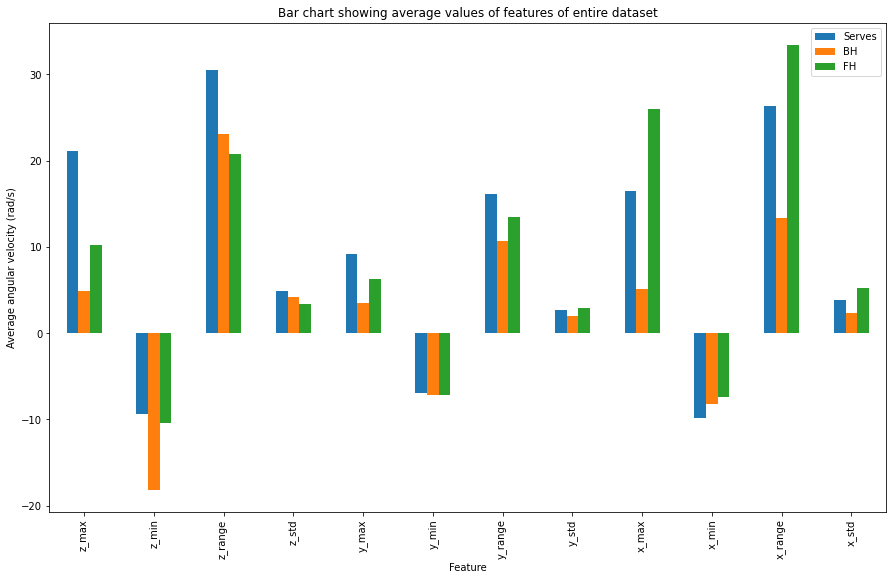

In [91]:
# Feature Extraction

def calc_features(example):
    feature_vals=[]
    feature_vals.append(max(example)) 
    feature_vals.append(min(example))
    feature_vals.append(max(example)-min(example))
    feature_vals.append(example.std())
    return feature_vals


X=[] # input data
Y=[] # gorund truth labels
AVG=[] # for average feature values
for swing in swings: # Serve, BH, FH]
    samples=[] # [FH1, FH2, FH3]
    cum_samples=np.zeros(12)
    for example in examples[swing]: # FH1
        feats=[]
        for col in ['z','y','x']:
            f_i=calc_features(example[col])
            feats.extend(f_i) # Add current feature to features
        samples.append(feats) # Add current array of features to swing array
        cum_samples=np.add(feats,cum_samples)
        Y.append(swing)
    X.append(samples) # add swing data to input array
    AVG.append(cum_samples) # cumulative values for particular swing


feat_heads=[]
heads=['max','min','range','std']
for col in ['z','y','x']:
    for h in heads:
        feat_heads.extend([col+'_'+h])

# Average feature values
AVG[0]=np.divide(AVG[0],len(examples["Serves"]))
AVG[1]=np.divide(AVG[1],len(examples["BH"]))
AVG[2]=np.divide(AVG[2],len(examples["FH"]))
average_stats = pd.DataFrame(AVG, swings, columns=feat_heads).transpose()

average_stats.plot(kind='bar',figsize=(15,9),xlabel="Feature",ylabel="Average angular velocity (rad/s)", title="Bar chart showing average values of features of entire dataset")


In [92]:
# Flatten Data
X=[]+X[0]+X[1]+X[2] #3D to 2D

In [93]:
visualise=pd.DataFrame(X,columns=feat_heads)
visualise['Y']=Y
display(visualise)

,z_max,z_min,z_range,z_std,y_max,y_min,y_range,y_std,x_max,x_min,x_range,x_std,Y
0,18.999969,-8.832183,27.832152,4.292512,11.784013,-6.996674,18.780687,2.646781,19.767611,-7.222312,26.989923,3.425271,Serves
1,20.898638,-7.595019,28.493657,4.870290,9.825575,-8.971730,18.797305,3.284513,22.595594,-9.813852,32.409447,4.183239,Serves
2,22.220957,-8.998112,31.219069,5.075703,8.991277,-8.471311,17.462587,2.838518,25.644047,-10.860636,36.504683,4.524852,Serves
3,20.586012,-8.303741,28.889753,4.376313,11.404284,-6.250504,17.654788,2.898650,22.478142,-8.817409,31.295550,3.770323,Serves
4,28.916561,-10.240948,39.157509,4.456699,9.074797,-6.778121,15.852917,2.648469,13.362346,-12.923007,26.285353,3.789030,Serves
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,8.159977,-19.707285,27.867262,4.300829,7.656522,-10.781308,18.437830,3.398218,24.310848,-7.311845,31.622693,5.215126,FH
88,13.209028,-19.457453,32.666481,4.362477,8.405077,-9.397863,17.802940,3.226708,30.114399,-8.874496,38.988894,5.967542,FH
89,8.662428,-7.073908,15.736336,2.537980,6.225943,-7.237372,13.463315,2.670788,22.575439,-5.211614,27.787054,4.743694,FH
90,15.987955,-2.260633,18.248588,3.088745,5.508439,-5.793467,11.301906,2.584572,18.428104,-6.237872,24.665976,4.366579,FH


In [18]:
#Select best features

select=SelectKBest(score_func=f_classif,k=1)
select.fit_transform(X,Y)
print(feat_heads)
print(select.get_support())

for f in range(11):
    if f==True:
        print("")

X_1=pd.DataFrame()
X_1['x_max']=visualise['x_max']

X_2=pd.DataFrame()
X_2['x_max']=visualise['x_max']
X_2['z_max']=visualise['z_max']

X_3=pd.DataFrame()
X_3['x_max']=visualise['x_max']
X_3['z_max']=visualise['z_max']
X_3['z_max']=visualise['x_std']
#X_new['x_std']=visualise['x_std']


['z_max', 'z_min', 'z_range', 'z_std', 'y_max', 'y_min', 'y_range', 'y_std', 'x_max', 'x_min', 'x_range', 'x_std']
[False False False False False False False False  True False False False]



,x_max,z_max
0,19.767611,18.999969
1,22.595594,20.898638
2,25.644047,22.220957
3,22.478142,20.586012
4,13.362346,28.916561
...,...,...
87,24.310848,8.159977
88,30.114399,13.209028
89,22.575439,8.662428
90,18.428104,15.987955


[0.75       1.         1.         0.93333333 0.86666667 0.8       ]
[1.         1.         1.         1.         1.         0.93333333]
[0.875      1.         1.         0.93333333 0.86666667 0.86666667]
   1 Feature  2 Features  3 Features
0   0.750000    1.000000    0.875000
1   1.000000    1.000000    1.000000
2   1.000000    1.000000    1.000000
3   0.933333    1.000000    0.933333
4   0.866667    1.000000    0.866667
5   0.800000    0.933333    0.866667


Text(0.5, 1.0, 'Box and whisker plot of model accuracy')

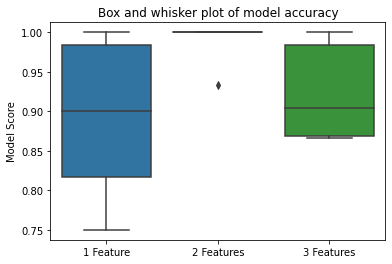

In [57]:
# Machine Learning
#train different models
import seaborn
#X_train,X_test,Y_train,Y_test=train_test_split(X_new,Y,test_size=0.5)
#model=svm.LinearSVC(max_iter=10)
#model.fit(X_train,Y_train)
model=svm.SVC(kernel='linear')
C=6
scores1=cross_val_score(model,X_1,Y, cv=C)
scores2=cross_val_score(model,X_2,Y, cv=C)
scores3=cross_val_score(model,X_3,Y, cv=C)

#acc=np.array([scores1,scores2])
acc=pd.DataFrame(data=[scores1,scores2,scores3]).transpose()
acc.set_axis(['1 Feature', '2 Features', '3 Features'], axis=1, inplace=True)
#print(acc)
# for sz in range(1,5):
#     X_train,X_test,Y_train,Y_test=train_test_split(X_new,Y,test_size=0.2*sz)
#     for itr in range(10):
#         model=svm.LinearSVC(max_iter=50*itr)
#         model.fit(X_train,Y_train) 
#         acc.append(model.score(X_test,Y_test))
# scores=cross_val_score(model,X,Y,cv=5)
# a=seaborn.boxplot(data=acc)
# a.set_ylabel("Model Score")
# plt.title("Box and whisker plot of model accuracy")

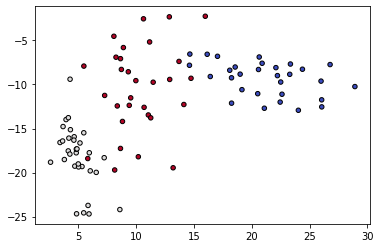

In [95]:
# Visualizing the results
import matplotlib.pyplot as plt
Xte, Xtr = np.array(X)[:,0], np.array(X)[:,1]
#print(X0)

col=np.zeros(len(Y))
for i in range(len(Y)):
    if Y[i]=='Serves':
        col[i]=0
    elif Y[i]=='BH':
        col[i]=1
    elif Y[i]=='FH':
        col[i]=2

plt.scatter(Xte,Xtr,c=col,cmap=plt.cm.coolwarm, s=20, edgecolors='k')#xlabel='x_max',ylabel='z_max')


Text(0, 0.5, 'z_max')

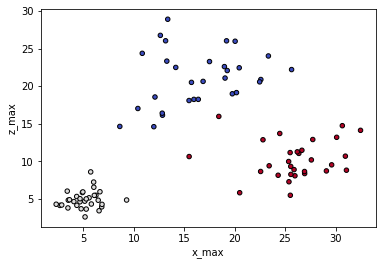

In [97]:
# Visualizing the results
import matplotlib.pyplot as plt
Xte, Xtr = np.array(X_2)[:,0], np.array(X_2)[:,1]
#print(X0)

col=np.zeros(len(Y))
for i in range(len(Y)):
    if Y[i]=='Serves':
        col[i]=0
    elif Y[i]=='BH':
        col[i]=1
    elif Y[i]=='FH':
        col[i]=2

plt.scatter(Xte,Xtr,c=col,label=['Serves','BH','FH'],cmap=plt.cm.coolwarm, s=20, edgecolors='k')#xlabel='x_max',ylabel='z_max')
plt.xlabel('x_max')
plt.ylabel('z_max')
#srves = mpatches.Patch(color='red', label='The red data')
